# CPU analysis of single-cell ATAC-seq data from 60K cells

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

### Import requirements

In [1]:
%%time
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from collections import OrderedDict

import time
import os

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

CPU times: user 1.89 s, sys: 6.34 s, total: 8.22 s
Wall time: 9.57 s


## Set parameters

In [3]:
# filtering peaks
n_top_peaks = 25000 # Number of peaks to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE
n_jobs=32

# KNN
n_neighbors = 10 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.4 
umap_spread = 1.0

# Differential peaks
n_diff_peaks = 50 # Number of differential peaks to compute for each cluster

# Marker genes
# Gene coordinates are in GRCh37, from grch37.ensembl.org
markers = ['MS4A1', 'LEF1', 'NKG7', 'TREM1', 'GATA1', 'PAX5']
marker_coords = OrderedDict()
marker_coords['MS4A1'] = ['chr11', 60223225, 60238233, 'fwd']
marker_coords['LEF1'] = ['chr4', 108968701, 109090112, 'rev']
marker_coords['NKG7'] = ['chr19', 51874860, 51875969, 'rev']
marker_coords['TREM1'] = ['chr6', 41235664, 41254457, 'rev']
marker_coords['GATA1'] = ['chrX', 48644962, 48652716, 'fwd']
marker_coords['PAX5'] = ['chr9', 36833272, 37034103, 'rev']

In [3]:
start_time = time.time()

## Input data

In [4]:
%%time
adata = anndata.read_h5ad('../data/dsci_resting_nonzeropeaks.h5ad')
adata_raw = adata.copy()

CPU times: user 447 ms, sys: 707 ms, total: 1.15 s
Wall time: 21.2 s


## Preprocessing

In [5]:
preprocessing_start = time.time()

### tf-idf normalization

We use log1p(pseudocount / tf)\*idf, motivated by discussion in [this blog post](http://andrewjohnhill.com/blog/2019/05/06/dimensionality-reduction-for-scatac-data/) as well as our results on various scATAC datasets.

In [5]:
%%time
lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

CPU times: user 2.6 s, sys: 833 ms, total: 3.44 s
Wall time: 3.44 s


### Frequency-based peak selection

In [6]:
%%time
peak_frequency = np.array(np.sum(adata.X > 0, axis=0) / adata.X.shape[0]).flatten()
frequent_peak_idxs = np.argsort(peak_frequency)

CPU times: user 560 ms, sys: 106 ms, total: 666 ms
Wall time: 665 ms


In [7]:
%%time
use = frequent_peak_idxs[-n_top_peaks : ]
adata = adata[:, use]

CPU times: user 18.7 ms, sys: 0 ns, total: 18.7 ms
Wall time: 20 ms


/rapids-genomics/rapidgenomics015/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [9]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 3.01sec


## Cluster & Visualize

### PCA

In [8]:
%%time
sc.pp.pca(adata, n_comps = n_components)

CPU times: user 9min 33s, sys: 1h 31min 26s, total: 1h 41min
Wall time: 5min 13s


### UMAP visualization

In [9]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 34.7 s, sys: 6.57 s, total: 41.3 s
Wall time: 41.2 s


In [10]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 1min 56s, sys: 4min 6s, total: 6min 2s
Wall time: 1min 19s


### Graph clustering

In [11]:
%%time
sc.tl.louvain(adata)

CPU times: user 6.14 s, sys: 76.2 ms, total: 6.22 s
Wall time: 6.19 s


In [12]:
%%time
sc.tl.leiden(adata)

CPU times: user 14.4 s, sys: 18.8 ms, total: 14.5 s
Wall time: 14.4 s


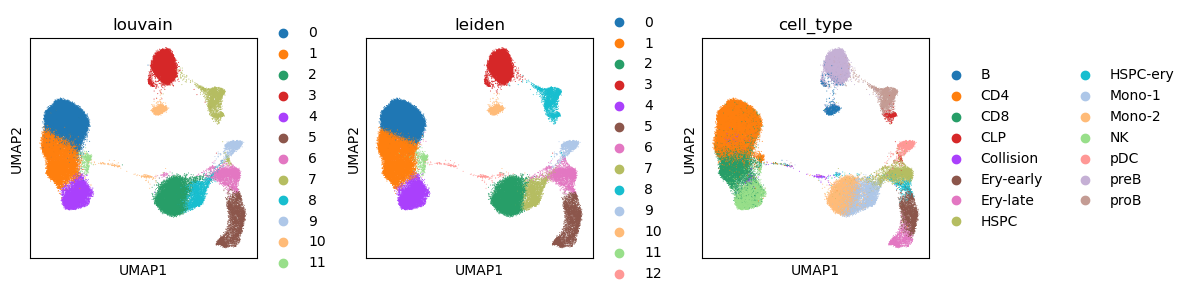

CPU times: user 2.66 s, sys: 2.3 s, total: 4.96 s
Wall time: 12.5 s


In [22]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.umap(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.umap(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.umap(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

### tSNE visualization

In [23]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, n_jobs=n_jobs)

CPU times: user 27min 4s, sys: 0 ns, total: 27min 4s
Wall time: 3min 28s


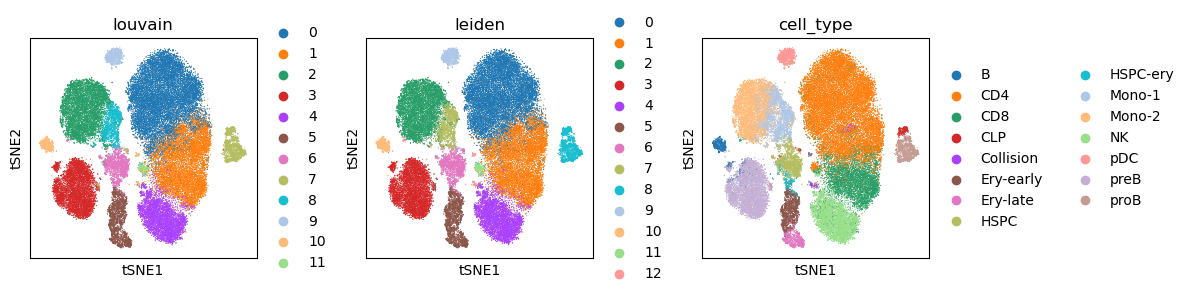

CPU times: user 3.39 s, sys: 1.92 s, total: 5.3 s
Wall time: 12.7 s


In [28]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.tsne(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.tsne(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.tsne(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

### Visualize marker gene activities

We use the raw adata object to compute gene activity scores. This allows us to consider all peaks, not just the subset we used for clustering and UMAP.

In [29]:
%%time
# find which peaks overlap with each marker gene (+ 5kb upstream)
peaks_per_gene = {gene : [] for gene in markers}

for (i, peak) in enumerate(adata_raw.var_names):
    chrom, coords = peak.strip().split(':')
    start, end = [int(c) for c in coords.split('-')]
    for gene in markers:
        if utils.overlap(marker_coords[gene], [chrom, start, end], 5000, 0):
            peaks_per_gene[gene].append((i, peak))

for gene in peaks_per_gene:
    print(f"{gene} has {len(peaks_per_gene[gene])} nearby peaks")

MS4A1 has 2 nearby peaks
LEF1 has 30 nearby peaks
NKG7 has 4 nearby peaks
TREM1 has 5 nearby peaks
GATA1 has 6 nearby peaks
PAX5 has 30 nearby peaks
CPU times: user 639 ms, sys: 869 µs, total: 639 ms
Wall time: 638 ms


In [30]:
%%time
# Calculate per-cell gene activity scores for each marker gene
cell_gene_scores = np.zeros((adata.X.shape[0], len(marker_coords.keys())))
for (i, gene) in enumerate(peaks_per_gene.keys()):
    indices = [x[0] for x in peaks_per_gene[gene]]
    peak_scores = adata_raw.X[:, indices].toarray()
    cell_gene_scores[:, i] = np.sum(peak_scores, axis=1) + 1

# Store per-cell gene activity scores with adata
for (i, gene) in enumerate(markers):
    adata.obs[gene] = np.log2(cell_gene_scores[:, i].tolist())
    adata.obs.loc[np.isneginf(adata.obs[gene]), gene] = 0

CPU times: user 2.05 s, sys: 0 ns, total: 2.05 s
Wall time: 2.05 s


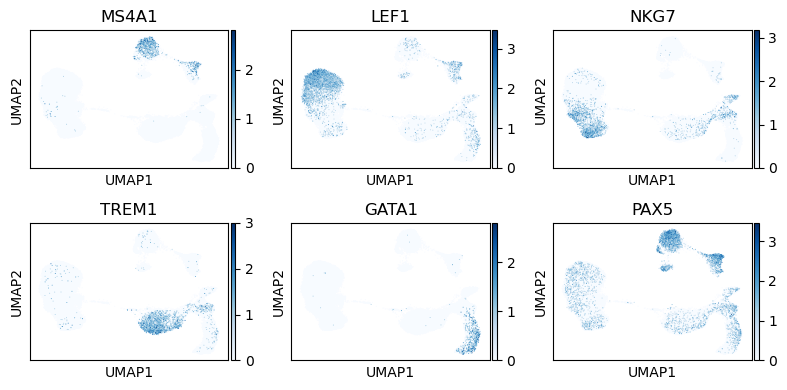

CPU times: user 2.26 s, sys: 444 ms, total: 2.71 s
Wall time: 3.51 s


In [31]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (8, 4), dpi=100)
axs = axs.flatten()
for (i, gene) in enumerate(markers):
    sc.pl.umap(adata, color_map="Blues", color=gene, ax = axs[i], show=False)
plt.tight_layout()
plt.show()

## Find differential peaks

We use a logistic regression model to find peaks that show differential activity across clusters. Here, we needed to increase the maximum number of iterations to 1200 for the model to converge.

In [32]:
%%time
sc.tl.rank_genes_groups(adata, 
                        groupby="louvain", 
                        n_genes=n_diff_peaks, 
                        groups='all', 
                        reference='rest',
                        method='logreg',
                        max_iter=1200
                       )

KeyboardInterrupt: 

In [33]:
%%time

fig, axs = plt.subplots(len(adata.uns['rank_genes_groups']['names'][0])//3 + 1, 3, figsize=(9,9), dpi=100)
axs = axs.flatten()

for (i, peak) in enumerate(adata.uns['rank_genes_groups']['names'][0]):
    sc.pl.umap(adata, color=peak, 
           ax=axs[i], show=False,
           vmax=min(25, np.max(adata[:,peak].X)),
           cmap='viridis'
          )
plt.tight_layout()
plt.show()

KeyError: 'names'

In [22]:
print("Full time: %s" % (time.time() - start_time))

Full time: 1634.2012920379639
